In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import os

from keras.layers.core import Dense,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
# Setup
path = './data/hmdb51'
path_rowframes = './data/hmdb51/rawframes/'
path_annotations = './data/hmdb51/annotations/'

img_height = 224
img_width = 224
batch_size = 32
num_classes = 51

# Motion Stream Model Definition

In [3]:
checkpoint_filepath = './Models/motion_model_val_acc_best.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_sparse_categorical_accuracy',
    mode='max',
    save_best_only=True)

In [4]:
num_classes = 51

model_mot= keras.models.Sequential()

# data_augmentation

model_mot.add(keras.layers.Conv2D(96, (7,7), strides = 2, input_shape=(224, 224, 20), activation = "relu"))
model_mot.add(keras.layers.BatchNormalization())
model_mot.add(keras.layers.MaxPooling2D((3,3), strides=2, padding="same"))

model_mot.add(keras.layers.ZeroPadding2D(padding = (1,1)))
model_mot.add(keras.layers.Conv2D(256, (5,5), strides = 2, activation='relu'))
model_mot.add(keras.layers.BatchNormalization())
model_mot.add(keras.layers.MaxPooling2D((3,3), strides=2, padding="same"))
          
model_mot.add(keras.layers.ZeroPadding2D(padding = (1,1)))
model_mot.add(keras.layers.Conv2D(512, (3,3), strides = 1, activation='relu'))

model_mot.add(keras.layers.ZeroPadding2D(padding = (1,1)))
model_mot.add(keras.layers.Conv2D(512, (3,3), strides = 1, activation='relu'))

model_mot.add(keras.layers.ZeroPadding2D(padding = (1,1)))
model_mot.add(keras.layers.Conv2D(512, (3,3), strides = 1, activation='relu'))
model_mot.add(keras.layers.MaxPooling2D((3,3), strides=2, padding="same"))

model_mot.add(keras.layers.Flatten())

model_mot.add(keras.layers.Dense(4096, activation='relu')) #1024
model_mot.add(keras.layers.Dropout(0.5))

model_mot.add(keras.layers.Dense(2048, activation='relu')) #512
model_mot.add(keras.layers.Dropout(0.5))

model_mot.add(keras.layers.Dense(num_classes, activation="softmax"))

In [5]:
model_mot.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 109, 109, 96)      94176     
                                                                 
 batch_normalization (BatchN  (None, 109, 109, 96)     384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 55, 55, 96)       0         
 )                                                               
                                                                 
 zero_padding2d (ZeroPadding  (None, 57, 57, 96)       0         
 2D)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                        

In [6]:
learning_rate = 1e-2
momentum = 0.9
optimizer = keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum, nesterov=True)
# keras.optimizers.Adam(learning_rate=0.001)

model_mot.compile(loss=keras.losses.sparse_categorical_crossentropy, 
                   metrics=['sparse_categorical_accuracy','sparse_top_k_categorical_accuracy'], 
                   optimizer=optimizer)

# Batch Generation Setting

In [7]:
# Setup
path = './data/hmdb51'
path_rowframes = './data/hmdb51/rawframes/'
path_annotations = './data/hmdb51/annotations/'

img_height = 224
img_width = 224
batch_size = 32
num_classes = 51

# Parametri del batch generator
num_of_snip=1
opt_flow_len=10
image_shape=(img_height, img_width)
epochs = 100

In [61]:
class DataSet():
    def __init__(self, 
                 num_of_snip=1, 
                 opt_flow_len=10, 
                 image_shape=(224, 224),
                 partition='train'):
        
    # opt_flow_len = (int) number of optical flow frames pet stacked optical flow (snip)

        self.opt_flow_len = opt_flow_len
        self.num_of_snip = num_of_snip
        self.image_shape = image_shape
        self.opt_flow_path = os.path.join(path_rowframes)
        self.path_annotations = path_annotations
        self.partition = partition
        
        # Get data
        self.video_list = self.find_videos_and_metadata()
        
    def find_videos_and_metadata(self):
        if self.partition == 'train':
            video_list = pd.read_csv(f'{self.path_annotations}/hmdb51_train_split_1_rawframes.txt', sep=" ", header=None) #train
            video_list.columns = ["path", "num_frames_tot", "class"]
        elif self.partition == 'val':
            video_list = pd.read_csv(f'{self.path_annotations}/hmdb51_val_split_1_rawframes.txt', sep=" ", header=None) #test
            video_list.columns = ["path", "num_frames_tot", "class"]
        else:
            raise Exception("invalid partition")
        return(video_list)
    
    def generator(self, batch_size):
        video_list = self.video_list
        idx = 0
        # print(f"Creating {self.partition} with {len(self.video_list)} samples.")
        while 1:
            idx +=1
            #print(f"Generator creating batch {idx}")
            X, y = [], []
            for _ in range(batch_size):
                # Reset 
                stack = []

                # Get a random sample.
                row = video_list.sample(n=1).values.tolist()

                # Get the stacked optical flows from disk.
                stack = self.find_stacked_optical_flows(row)

                X.append(stack)
                y.append(row[0][2])

            X = np.array(X)
            y = np.array(y)
            y = np.squeeze(y)

            yield X, y
        
    def generator1(self, batch_size):
        video_list = self.video_list
        idx = 0
        # print(f"Creating {self.partition} with {len(self.video_list)} samples.")
        idx +=1
        #print(f"Generattor creating batch {idx}")
        X, y = [], []
        for _ in range(batch_size):
            # Reset 
            stack = []

            # Get a random sample.
            row = video_list.sample(n=1).values.tolist()

            # Get the stacked optical flows from disk.
            stack = self.find_stacked_optical_flows(row)
            # print(stack)
            X.append(stack)
            y.append(row[0][2])

        X = np.array(X)
        y = np.array(y)
        y = np.squeeze(y)

        return X, y
    
            
    def find_stacked_optical_flows(self, row):
        opt_flow_stack = []
        opt_flow_dir = self.opt_flow_path
        
        # Temporal parameters
        total_frames = row[0][1]
        win_len = (total_frames - self.opt_flow_len) // self.num_of_snip
        if self.partition=='train':
            start_frame = int(random.random() * win_len) + 1
        else:
            start_frame = int(0.5 * win_len) + 1
        frames = [] # selected optical flow frames
        for i in range(self.num_of_snip):
            frames += range(start_frame + self.opt_flow_len * i, 
                            start_frame + self.opt_flow_len * (i + 1))  
        if self.partition == 'train' and random.random() > 0.5:
            flip = True
        else:
            flip = False
        
        # Spatial Parameter
        img_test = cv2.imread(os.path.join(f'.\\{row[0][0]}' + '\\flow_x_' + str("%05d"%(1)) + '.jpg'), 0) # Legge immagine in BGR
        # print(f'image test shape:{img_test.shape}')
        if img_test.shape[1] >= self.image_shape[1]:
            top = int((img_test.shape[0] - self.image_shape[0]) * random.random())
            left = int((img_test.shape[1] - self.image_shape[1]) * random.random())
            right = left + self.image_shape[1]
            bottom = top + self.image_shape[0]
        else: 
            top = int((img_test.shape[0] - self.image_shape[0]) * random.random())
            bottom = top + self.image_shape[0]
            left = 0
            right = img_test.shape[1]
        # print(f'top{top}bottom{bottom}left{left}right{right}')
        
        # loop over frames
        for i_frame in frames:
            # x flow
            img = None # reset to be safe
            temp_path = None
            temp_path = row[0][0]
            img = cv2.imread(os.path.join(f'.\\{temp_path}' + '\\flow_x_' + str("%05d"%(i_frame)) + '.jpg'), 0)
            #print(os.path.join(f'.\\{temp_path}' + '\\flow_x_' + str("%05d"%(i_frame)) + '.jpg'))
            #print(img.shape)
            img = np.array(img)
            # mean substraction 
            img = img - np.mean(img)                       # Centratura rispetto alla media dei pixel dell'immagine
            if self.partition == 'train':
                # random crop
                img = img[top : bottom, left : right]
                print(img.shape)
            else:
                #resize
                img = cv2.resize(img, self.image_shape)
            img = img / 255. # normalize pixels 
            if flip:
                img = -img
            img = cv2.resize(img, self.image_shape)
            #print(img.shape)
            opt_flow_stack.append(img)
            
            # y flow
            img2 = None # reset to be safe
            img2 = cv2.imread(os.path.join(f'.\\{temp_path}' + '\\flow_y_' + str("%05d"%(i_frame)) + '.jpg'), 0)
            #print(img2.shape)
            img2 = np.array(img2)
            #img2 = np.swapaxes(img2, 0, 1)
            img2 = img2 - np.mean(img2) # Centra immagini rispetto alla media
            if self.partition == 'train':
                 #random crop
                img2 = img2[top : bottom, left : right]
                print(img.shape)
            else:
                #resize
                img2= cv2.resize(img2, self.image_shape)
            img2 = img2 / 255. # normalize pixels (dopo averli centrati, quindi andrà da -1 a 1)
            if flip:
                img2 = -img2
            img2 = cv2.resize(img2, self.image_shape)
            #print(img2.shape)
            opt_flow_stack.append(img2)
            
        opt_flow_stack = np.array(opt_flow_stack)
        opt_flow_stack = np.swapaxes(opt_flow_stack, 0, 1)
        opt_flow_stack = np.swapaxes(opt_flow_stack, 1, 2)
        # random horizontal flip for training sets
        if flip:
            opt_flow_stack = np.flip(opt_flow_stack, 0)
        return opt_flow_stack
            
        

# Testing

### Test corretto funzionamento cropping randomico

Test del calcolo dei valori di cropping (superato sono corretti)

In [65]:
videos_train = DataSet(num_of_snip=num_of_snip, opt_flow_len=opt_flow_len, partition='train')
X, y = videos_train.generator1(32)

image test shape:(240, 416)
top9bottom233left121right345
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
image test shape:(240, 320)
top1bottom225left10right234
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
image test shape:(240, 320)
top12bottom236left67right291
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
image test shape:(240, 320)
top10bottom234left60right284
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(22

Test caso specifico dove il crop non funziona bene: quando una delle dimensioni è minore di 224 viene dato un valore negativo
- Il crop con valore negativo resistuisce un array rotto
- Introdotto un crop specifico per questa casistica

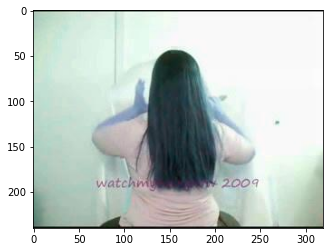

In [128]:
from matplotlib import pyplot as plt
img_test = cv2.imread(os.path.join(f'.\\data\\hmdb51\\rawframes\\brush_hair\\April_09_brush_hair_u_nm_np1_ba_goo_0\\' + '\\img_' + str("%05d"%(1)) + '.jpg'), 3)
#img2 = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)
plt.imshow(img_test)

In [118]:
img_test

array([[[  0,  11,   0],
        [  0,  11,   0],
        [  0,  12,   1],
        ...,
        [  5,   5,   5],
        [  5,   5,   5],
        [  5,   5,   5]],

       [[ 90, 106,  95],
        [ 90, 107,  96],
        [ 91, 107,  96],
        ...,
        [131, 131, 131],
        [131, 131, 131],
        [131, 131, 131]],

       [[187, 204, 193],
        [185, 205, 193],
        [188, 205, 194],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       ...,

       [[ 99, 120, 112],
        [ 98, 121, 113],
        [102, 123, 115],
        ...,
        [153, 162, 142],
        [154, 160, 141],
        [155, 159, 140]],

       [[ 48,  65,  61],
        [ 46,  66,  61],
        [ 50,  68,  61],
        ...,
        [ 74,  83,  63],
        [ 75,  81,  62],
        [ 75,  81,  62]],

       [[  0,  13,   9],
        [  0,  13,   9],
        [  0,  14,   7],
        ...,
        [  5,  14,   0],
        [  6,  12,   0],
        [  6,  12,   0]]

In [123]:
#img_test.shape
np.mean(img_test)

192.59690972222222

In [60]:
plt.imshow(cv2.resize(img_test[-32:208, 0:320], (224,224)))

error: OpenCV(4.5.1) C:\Users\giorg\Downloads\opencv-4.5.1\modules\imgproc\src\resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'


### Test normalizzazione

In [119]:
#img_test_norm = img_test - np.mean(img_test) # non va bene su più canali, ma solo su UNO
#img_test_norm = img_test_norm / 255.
#plt.imshow(img_test_norm)
img_test_norm_imagenet_keras = tf.keras.applications.resnet.preprocess_input(img_test)
#plt.imshow(img_test_norm)

In [95]:
cv2.imshow("Normalize Keras", img_test_norm)
cv2.waitKey(0)
cv2.destroyAllWindows() 

Test per verificare la normalizzazione necessaria per 

In [120]:
img_test_norm_imagenet_keras

array([[[-103.939    , -105.779    , -123.68     ],
        [-103.939    , -105.779    , -123.68     ],
        [-102.939    , -104.779    , -123.68     ],
        ...,
        [ -98.939    , -111.779    , -118.68     ],
        [ -98.939    , -111.779    , -118.68     ],
        [ -98.939    , -111.779    , -118.68     ]],

       [[  -8.939003 ,  -10.778999 ,  -33.68     ],
        [  -7.939003 ,   -9.778999 ,  -33.68     ],
        [  -7.939003 ,   -9.778999 ,  -32.68     ],
        ...,
        [  27.060997 ,   14.221001 ,    7.3199997],
        [  27.060997 ,   14.221001 ,    7.3199997],
        [  27.060997 ,   14.221001 ,    7.3199997]],

       [[  89.061    ,   87.221    ,   63.32     ],
        [  89.061    ,   88.221    ,   61.32     ],
        [  90.061    ,   88.221    ,   64.32     ],
        ...,
        [ 150.061    ,  137.22101  ,  130.32     ],
        [ 150.061    ,  137.22101  ,  130.32     ],
        [ 150.061    ,  137.22101  ,  130.32     ]],

       ...,

      

In [124]:
img_test_norm_net = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)
img_test_norm_net = img_test_norm_net - [103.939, 116.779, 123.68]
#img_test_norm_net = img_test_norm_net / [0.229, 0.224, 0.225]
img_test_norm_net

array([[[-103.939, -105.779, -123.68 ],
        [-103.939, -105.779, -123.68 ],
        [-102.939, -104.779, -123.68 ],
        ...,
        [ -98.939, -111.779, -118.68 ],
        [ -98.939, -111.779, -118.68 ],
        [ -98.939, -111.779, -118.68 ]],

       [[  -8.939,  -10.779,  -33.68 ],
        [  -7.939,   -9.779,  -33.68 ],
        [  -7.939,   -9.779,  -32.68 ],
        ...,
        [  27.061,   14.221,    7.32 ],
        [  27.061,   14.221,    7.32 ],
        [  27.061,   14.221,    7.32 ]],

       [[  89.061,   87.221,   63.32 ],
        [  89.061,   88.221,   61.32 ],
        [  90.061,   88.221,   64.32 ],
        ...,
        [ 150.061,  137.221,  130.32 ],
        [ 150.061,  137.221,  130.32 ],
        [ 150.061,  137.221,  130.32 ]],

       ...,

       [[   8.061,    3.221,  -24.68 ],
        [   9.061,    4.221,  -25.68 ],
        [  11.061,    6.221,  -21.68 ],
        ...,
        [  38.061,   45.221,   29.32 ],
        [  37.061,   43.221,   30.32 ],
        [

### Test Cap Numero di frame

In [130]:
video_list = pd.read_csv(f'{path_annotations}/hmdb51_train_split_1_rawframes.txt', sep=" ", header=None) #train
video_list.columns = ["path", "num_frames_tot", "class"]

In [134]:
len(video_list[video_list['num_frames_tot'] > 250])

146

In [71]:
# Setup
path = './data/hmdb51'
path_rowframes = './data/hmdb51/rawframes/'
path_annotations = './data/hmdb51/annotations/'

img_height = 224
img_width = 224
batch_size = 32
num_classes = 51

# Parametri del batch generator
num_of_snip=1
opt_flow_len=10
image_shape=(img_height, img_width)
epochs = 100

Aggiungo cap di 30 frame minimo e aumento il numero di snip a 2

In [135]:
class DataSet():
    def __init__(self, 
                 num_of_snip=1, 
                 opt_flow_len=10, 
                 image_shape=(224, 224),
                 partition='train'):
        
    # opt_flow_len = (int) number of optical flow frames pet stacked optical flow (snip)

        self.opt_flow_len = opt_flow_len
        self.num_of_snip = num_of_snip
        self.image_shape = image_shape
        self.opt_flow_path = os.path.join(path_rowframes)
        self.path_annotations = path_annotations
        self.partition = partition
        
        # Get data
        self.video_list = self.find_videos_and_metadata()
        
    def find_videos_and_metadata(self):
        if self.partition == 'train':
            video_list = pd.read_csv(f'{self.path_annotations}/hmdb51_train_split_1_rawframes.txt', sep=" ", header=None) #train
            video_list.columns = ["path", "num_frames_tot", "class"]
            # video_list = video_list[video_list['num_frames_tot'] > 30] # Aggiunto cap
        elif self.partition == 'val':
            video_list = pd.read_csv(f'{self.path_annotations}/hmdb51_val_split_1_rawframes.txt', sep=" ", header=None) #test
            video_list.columns = ["path", "num_frames_tot", "class"]
            # video_list = video_list[video_list['num_frames_tot'] > 30] # Aggiunto cap
        else:
            raise Exception("invalid partition")
        return(video_list)
    
    def generator(self, batch_size):
        video_list = self.video_list
        idx = 0
        # print(f"Creating {self.partition} with {len(self.video_list)} samples.")
        while 1:
            idx +=1
            #print(f"Generator creating batch {idx}")
            X, y = [], []
            for _ in range(batch_size):
                # Reset 
                stack = []

                # Get a random sample.
                row = video_list.sample(n=1).values.tolist()

                # Get the stacked optical flows from disk.
                stack = self.find_stacked_optical_flows(row)

                X.append(stack)
                y.append(row[0][2])

            X = np.array(X)
            y = np.array(y)
            y = np.squeeze(y)

            yield X, y
        
    def generator1(self, batch_size):
        video_list = self.video_list
        idx = 0
        print(f"Creating {self.partition} with {len(self.video_list)} samples.")
        idx +=1
        #print(f"Generattor creating batch {idx}")
        X, y = [], []
        for _ in range(batch_size):
            # Reset 
            stack = []

            # Get a random sample.
            row = video_list.sample(n=1).values.tolist()

            # Get the stacked optical flows from disk.
            stack = self.find_stacked_optical_flows(row)
            print(stack)
            X.append(stack)
            y.append(row[0][2])

        X = np.array(X)
        y = np.array(y)
        y = np.squeeze(y)

        return X, y
    
            
    def find_stacked_optical_flows(self, row, val_aug='center'):
        opt_flow_stack = []
        opt_flow_dir = self.opt_flow_path
        
        # Temporal parameters
        total_frames = row[0][1]
        win_len = (total_frames - self.opt_flow_len) // self.num_of_snip # numero di frame (es. 17) - lunghezza stack (es.10) // numero di snip (es.1) = win_len (es. 7)
        if self.partition=='train':
            start_frame = int(random.random() * win_len) + 1 #la win_len moltiplicata per un numero random tra 0 e 1 restituisce sempre un frame iniziale in modo che lo stack non sfori il numero totale di frame
        else:
            start_frame = int(0.5 * win_len) + 1 # per il validation prende sempre il frame numero win_len / 2
        frames = [] # un vettore di indici relativi ai frame, per ogni snip un append con un certo numero di frame
        
        # LOOPING: non può funzionare così com'è -> se il numero di snip > 10 non avrei più stack da 10 frame
        """for i in range(self.num_of_snip): # per ogni snip genera 10 frame (tutti accumulati in un solo vettore monodimensionale)
            frames += range(start_frame + self.opt_flow_len * i,  
                            start_frame + self.opt_flow_len * (i + 1)) # se il numero di snip è 1 allora avrò solo un range [stat_frame, start_frame + 10]  """
            
        if self.partition == 'train' and random.random() > 0.5:
            flip = True
        else:
            flip = False
        
        # Spatial Parameter
        img_test = cv2.imread(os.path.join(f'.\\{row[0][0]}' + '\\flow_x_' + str("%05d"%(1)) + '.jpg'), 0)
        
        """left, top = random.choice([[0, 0], [0, self.original_image_shape[1] - self.image_shape[1]], 
                                   [self.original_image_shape[0] - self.image_shape[0], 0], 
                                   [self.original_image_shape[0] - self.image_shape[0], self.original_image_shape[1] - self.image_shape[1]], 
                                   [int((self.original_image_shape[0] - self.image_shape[0]) * 0.5), int((self.original_image_shape[1] - self.image_shape[1]) * 0.5)]])"""
        
        if self.partition == 'train':
            top = int((img_test.shape[0] - self.image_shape[0]) * random.random())
            left = int((img_test.shape[1] - self.image_shape[1]) * random.random())
        else:
            top = int((img_test.shape[0] - self.image_shape[0]) * 0.5)
            left = int((img_test.shape[1] - self.image_shape[1]) * 0.5)
        right = left + self.image_shape[1]
        bottom = top + self.image_shape[0]
        
        # loop over frames
        for i_frame in frames:
            # x flow
            img = None # reset to be safe
            temp_path = None
            temp_path = row[0][0]
            img = cv2.imread(os.path.join(f'.\\{temp_path}' + '\\flow_x_' + str("%05d"%(i_frame)) + '.jpg'), 0)
            #print(os.path.join(f'.\\{temp_path}' + '\\flow_x_' + str("%05d"%(i_frame)) + '.jpg'))
            #print(img.shape)
            img = np.array(img)
            # mean substraction 
            img = img - np.mean(img)
            if self.partition == 'train' or val_aug == 'center':
                # random crop
                img = img[top : bottom, left : right]
            else:
                #resize
                img = cv2.resize(img, self.image_shape)
            img = img / 255. # normalize pixels 
            if flip:
                img = -img
            img = cv2.resize(img, self.image_shape)
            #print(img.shape)
            opt_flow_stack.append(img)
            
            # y flow
            img2 = None # reset to be safe
            img2 = cv2.imread(os.path.join(f'.\\{temp_path}' + '\\flow_y_' + str("%05d"%(i_frame)) + '.jpg'), 0)
            #print(img2.shape)
            img2 = np.array(img2)
            #img2 = np.swapaxes(img2, 0, 1)
            img2 = img2 - np.mean(img2)
            if self.partition == 'train' or val_aug == 'center':
                 #random crop
                img2 = img2[top : bottom, left : right]
            else:
                #resize
                img2= cv2.resize(img2, self.image_shape)
            img2 = img2 / 255. # normalize pixels 
            if flip:
                img2 = -img2
            img2 = cv2.resize(img2, self.image_shape)
            #print(img2.shape)
            opt_flow_stack.append(img2)
            
        opt_flow_stack = np.array(opt_flow_stack)
        opt_flow_stack = np.swapaxes(opt_flow_stack, 0, 1)
        opt_flow_stack = np.swapaxes(opt_flow_stack, 1, 2)
        # random horizontal flip for training sets
        if flip:
            opt_flow_stack = np.flip(opt_flow_stack, 0)
        return opt_flow_stack
            
        

In [155]:
lista = []
lista += range(10)
lista += range(10,21)
lista

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [154]:
12 // 5

2

In [152]:
int(1.5)

1

# Model Fit

In [9]:
videos_train = DataSet(num_of_snip=num_of_snip, opt_flow_len=opt_flow_len, partition='train')
videos_val = DataSet(num_of_snip=num_of_snip, opt_flow_len=opt_flow_len, partition='val')

Fit

In [10]:
train_generator = videos_train.generator(batch_size)

val_generator = videos_val.generator(batch_size)

In [11]:
# batch size 
step_per_epoch_train = len(videos_train.video_list) // batch_size
print(step_per_epoch_train)
step_per_epoch_val = len(videos_val.video_list) // batch_size
print(step_per_epoch_val)

111
47


In [12]:
# %tb
history_cnn_spatial_stream = model_mot.fit_generator(generator =train_generator, 
                                            steps_per_epoch=step_per_epoch_train, 
                                            validation_data=val_generator,
                                            validation_steps=step_per_epoch_val, 
                                            epochs=5,
                                            callbacks=[model_checkpoint_callback])
                

c:\Users\giorg\Documents\venv\deepL37\lib\site-packages\ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Creating train with 3570 samples.
Epoch 1/5
111/111 [==============================] - 377s 3s/step - loss: 3.9799 - sparse_categorical_accuracy: 0.0256 - sparse_top_k_categorical_accuracy: 0.1154 - val_loss: 3.9321 - val_sparse_categorical_accuracy: 0.0140 - val_sparse_top_k_categorical_accuracy: 0.1044
Epoch 2/5
109/111 [============================>.] - ETA: 4s - loss: 3.9025 - sparse_categorical_accuracy: 0.0338 - sparse_top_k_categorical_accuracy: 0.1376

KeyboardInterrupt: 

In [29]:
score = model_mot.evaluate_generator(val_generator, verbose=1, steps=step_per_epoch_val)
#print('sparse_categorical_accuracy:', score[0])
#print('sparse_top_k_categorical_accuracy:', score[1])

c:\Users\giorg\Documents\venv\deepL37\lib\site-packages\ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


47/47 [==============================] - 55s 1s/step - loss: 3.3076 - sparse_categorical_accuracy: 0.2121 - sparse_top_k_categorical_accuracy: 0.4980


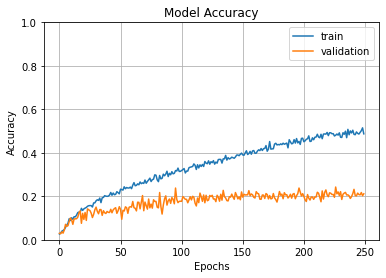

In [28]:
fig1 = plt.gcf()
plt.plot(history_cnn_spatial_stream.history['sparse_categorical_accuracy'])
plt.plot(history_cnn_spatial_stream.history['val_sparse_categorical_accuracy'])
plt.axis(ymin=0,ymax=1)
plt.grid()
plt.title('Model Accuracy')
metric_plot = 'Accuracy'
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.savefig(f'./Report/Plots/motion_stream/motion_stream_V1_epoch{epochs}_batch{batch_size}_optSDG_{learning_rate}_{momentum}_metric{metric_plot}.png')
plt.show()

In [32]:
model_mot.save(f'./Models/motion_stream/motion_stream_V1_epoch{epochs}_batch{batch_size}_optSDG_lr{learning_rate}_momentum{momentum}.h5')
# model_mot.save_weights('./Models/model_mot_weights.h5')